In [20]:
import numpy as np

def simulate_time_series(n_steps, seasonality_period, noise_level=0.1, seed=42):
    np.random.seed(seed)  # For reproducibility
    trend = np.linspace(0, 10, n_steps)
    seasonality = np.sin(np.linspace(0, 2 * np.pi * (n_steps / seasonality_period), n_steps))
    noise = np.random.normal(0, noise_level, n_steps)
    return trend + seasonality + noise

# Generate the time series data
n_steps = 5000
seasonality_period = 50
time_series_data = simulate_time_series(n_steps, seasonality_period)


In [21]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from models import ElmanRNN

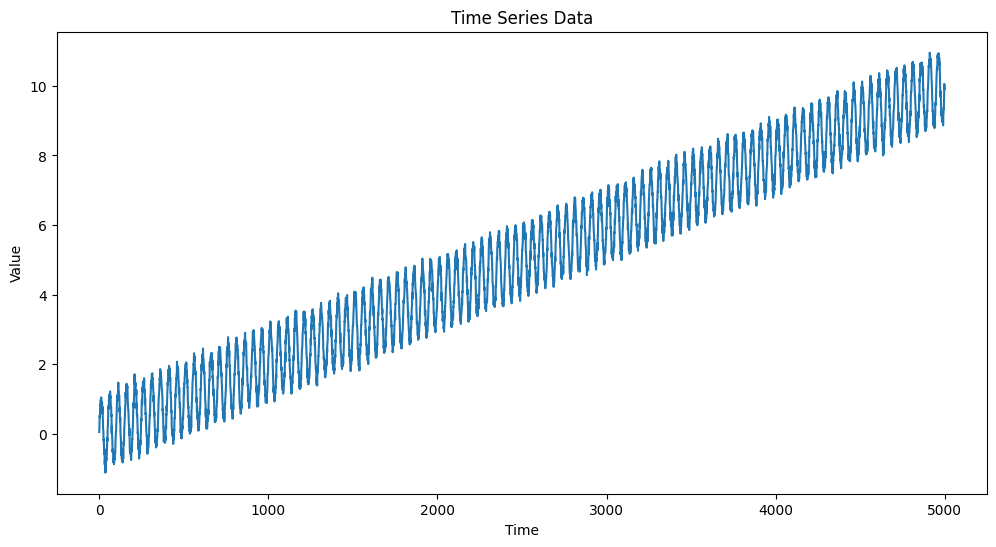

In [22]:
# Plot time series data
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(time_series_data)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Data')
plt.show()

In [23]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(time_series_data)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -0.1441601463968344
p-value: 0.94485847892832


In [24]:
diff_data = np.diff(time_series_data)

In [25]:
result2 = adfuller(diff_data)
print(f'ADF Statistic: {result2[0]}')
print(f'p-value: {result2[1]}')

ADF Statistic: -34.60592530787768
p-value: 0.0


In [26]:
# Import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler


def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

def train_validate_test_split(data, train_size=0.7, val_size=0.15):
    n = len(data)
    train_end = int(n * train_size)
    val_end = int(n * (train_size + val_size))
    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]
    return train_data, val_data, test_data

train_data, val_data, test_data = train_validate_test_split(diff_data)

scaler = MinMaxScaler()
scaler.fit(train_data.reshape(-1, 1))

train_data = scaler.transform(train_data.reshape(-1, 1)).flatten()
val_data = scaler.transform(val_data.reshape(-1, 1)).flatten()
test_data = scaler.transform(test_data.reshape(-1, 1)).flatten()


In [27]:

sequence_length = 50  # Example sequence length

X_train, y_train = create_sequences(train_data, sequence_length)
X_val, y_val = create_sequences(val_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

X_train = X_train.reshape(-1, sequence_length, 1)
X_val = X_val.reshape(-1, sequence_length, 1)
X_test = X_test.reshape(-1, sequence_length, 1)

y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [28]:
# Define the number of splits for cross-validation
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Hyperparameters
input_size = 1
hidden_size = 64
output_size = 1
num_layers = 1
learning_rate = 0.001
num_epochs = 20
batch_size = 64
sequence_length = 50  # Make sure this matches your original sequence length

# Function to create sequences
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Function to train and evaluate the model
def train_and_evaluate(X_train, y_train, X_val, y_val):
    train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
    val_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    model = ElmanRNN(input_size, hidden_size, output_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)
    
    # Evaluate on validation set
    model.eval()
    val_predictions, val_actuals = predict(model, val_loader)
    val_mse = mean_squared_error(val_actuals, val_predictions)
    
    return val_mse

# Perform time series cross-validation
cv_scores = []
for train_index, val_index in tscv.split(diff_data):
    X_train, X_val = diff_data[train_index], diff_data[val_index]
    
    # Create sequences for training and validation sets
    X_train, y_train = create_sequences(X_train, sequence_length)
    X_val, y_val = create_sequences(X_val, sequence_length)
    
    # Reshape the data
    X_train = X_train.reshape(-1, sequence_length, 1)
    X_val = X_val.reshape(-1, sequence_length, 1)
    y_train = y_train.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)
    
    # Scale the data
    X_train = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(-1, sequence_length, 1)
    X_val = scaler.transform(X_val.reshape(-1, 1)).reshape(-1, sequence_length, 1)
    y_train = scaler.transform(y_train)
    y_val = scaler.transform(y_val)
    
    val_mse = train_and_evaluate(X_train, y_train, X_val, y_val)
    cv_scores.append(val_mse)

# Print cross-validation results
print(f"Cross-validation MSE scores: {cv_scores}")
print(f"Mean MSE: {np.mean(cv_scores):.4f}, Std MSE: {np.std(cv_scores):.4f}")

Epoch 1/20, Train Loss: 0.0628, Val Loss: 0.0313
Epoch 2/20, Train Loss: 0.0283, Val Loss: 0.0291
Epoch 3/20, Train Loss: 0.0272, Val Loss: 0.0263
Epoch 4/20, Train Loss: 0.0258, Val Loss: 0.0260
Epoch 5/20, Train Loss: 0.0256, Val Loss: 0.0253
Epoch 6/20, Train Loss: 0.0249, Val Loss: 0.0248
Epoch 7/20, Train Loss: 0.0244, Val Loss: 0.0242
Epoch 8/20, Train Loss: 0.0238, Val Loss: 0.0234
Epoch 9/20, Train Loss: 0.0228, Val Loss: 0.0227
Epoch 10/20, Train Loss: 0.0221, Val Loss: 0.0232
Epoch 11/20, Train Loss: 0.0214, Val Loss: 0.0216
Epoch 12/20, Train Loss: 0.0205, Val Loss: 0.0207
Epoch 13/20, Train Loss: 0.0198, Val Loss: 0.0201
Epoch 14/20, Train Loss: 0.0193, Val Loss: 0.0196
Epoch 15/20, Train Loss: 0.0188, Val Loss: 0.0192
Epoch 16/20, Train Loss: 0.0184, Val Loss: 0.0188
Epoch 17/20, Train Loss: 0.0179, Val Loss: 0.0184
Epoch 18/20, Train Loss: 0.0174, Val Loss: 0.0181
Epoch 19/20, Train Loss: 0.0172, Val Loss: 0.0179
Epoch 20/20, Train Loss: 0.0174, Val Loss: 0.0182
Epoch 1/2

In [29]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from models import ElmanRNN

def perform_cv(params, diff_data, n_splits=5, sequence_length=50):
    """
    Perform cross-validation with given parameters.
    
    :param params: dict, hyperparameters for the model
    :param diff_data: numpy array, differenced time series data
    :param n_splits: int, number of splits for time series cross-validation
    :param sequence_length: int, length of input sequences
    :return: list, cross-validation MSE scores
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    cv_scores = []

    for train_index, val_index in tscv.split(diff_data):
        X_train, X_val = diff_data[train_index], diff_data[val_index]
        
        # Create sequences
        X_train, y_train = create_sequences(X_train, sequence_length)
        X_val, y_val = create_sequences(X_val, sequence_length)
        
        # Reshape and scale data
        X_train = X_train.reshape(-1, sequence_length, 1)
        X_val = X_val.reshape(-1, sequence_length, 1)
        y_train = y_train.reshape(-1, 1)
        y_val = y_val.reshape(-1, 1)
        
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(-1, sequence_length, 1)
        X_val = scaler.transform(X_val.reshape(-1, 1)).reshape(-1, sequence_length, 1)
        y_train = scaler.transform(y_train)
        y_val = scaler.transform(y_val)
        
        # Train and evaluate
        val_mse = train_and_evaluate(X_train, y_train, X_val, y_val, params)
        cv_scores.append(val_mse)
    
    return cv_scores

def train_final_model(params, full_data, sequence_length=50):
    """
    Train the final model on the full dataset using the best parameters.
    
    :param params: dict, best hyperparameters for the model
    :param full_data: numpy array, full time series data
    :param sequence_length: int, length of input sequences
    :return: trained ElmanRNN model
    """
    X, y = create_sequences(full_data, sequence_length)
    X = X.reshape(-1, sequence_length, 1)
    y = y.reshape(-1, 1)
    
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X.reshape(-1, 1)).reshape(-1, sequence_length, 1)
    y = scaler.transform(y)
    
    dataset = TensorDataset(torch.from_numpy(X).float(), torch.from_numpy(y).float())
    dataloader = DataLoader(dataset, batch_size=params['batch_size'], shuffle=False)
    
    model = ElmanRNN(input_size=1, 
                     hidden_size=params['hidden_size'], 
                     output_size=1, 
                     num_layers=params['num_layers'])
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    
    train_model(model, dataloader, dataloader, criterion, optimizer, params['num_epochs'])
    
    return model, scaler

def evaluate_on_test_set(model, scaler, test_data, sequence_length=50):
    """
    Evaluate the trained model on a held-out test set.
    
    :param model: trained ElmanRNN model
    :param scaler: fitted MinMaxScaler
    :param test_data: numpy array, test time series data
    :param sequence_length: int, length of input sequences
    :return: float, Mean Squared Error on test set
    """
    X_test, y_test = create_sequences(test_data, sequence_length)
    X_test = X_test.reshape(-1, sequence_length, 1)
    y_test = y_test.reshape(-1, 1)
    
    X_test = scaler.transform(X_test.reshape(-1, 1)).reshape(-1, sequence_length, 1)
    y_test = scaler.transform(y_test)
    
    test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
    
    model.eval()
    with torch.no_grad():
        predictions, _ = predict(model, test_loader)
    
    # Inverse transform predictions and actual values
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test)
    
    mse = mean_squared_error(y_test, predictions)
    return mse

# Helper function to create sequences (as defined earlier)
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Assuming train_model and predict functions are defined elsewhere in your code
# If not, you'll need to implement them based on your original training loop

In [30]:
import torch
import torch.nn as nn
from models import ElmanRNN

input_size = 1
hidden_size = 64  # Adjust as needed
output_size = 1
num_layers = 1
learning_rate = 0.001
num_epochs = 20
batch_size = 64


In [31]:

from torch.utils.data import TensorDataset, DataLoader

# Convert data to PyTorch tensors
train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [32]:
model = ElmanRNN(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [33]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        train_losses = []
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        val_losses = []
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                output = model(X_batch)
                loss = criterion(output, y_batch)
                val_losses.append(loss.item())
        model.train()

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {np.mean(train_losses):.4f}, Val Loss: {np.mean(val_losses):.4f}')

In [34]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch 1/20, Train Loss: 0.0230, Val Loss: 0.0196
Epoch 2/20, Train Loss: 0.0174, Val Loss: 0.0163
Epoch 3/20, Train Loss: 0.0146, Val Loss: 0.0142
Epoch 4/20, Train Loss: 0.0131, Val Loss: 0.0134
Epoch 5/20, Train Loss: 0.0125, Val Loss: 0.0127
Epoch 6/20, Train Loss: 0.0124, Val Loss: 0.0125
Epoch 7/20, Train Loss: 0.0108, Val Loss: 0.0105
Epoch 8/20, Train Loss: 0.0100, Val Loss: 0.0099
Epoch 9/20, Train Loss: 0.0098, Val Loss: 0.0114
Epoch 10/20, Train Loss: 0.0103, Val Loss: 0.0103
Epoch 11/20, Train Loss: 0.0097, Val Loss: 0.0101
Epoch 12/20, Train Loss: 0.0100, Val Loss: 0.0103
Epoch 13/20, Train Loss: 0.0096, Val Loss: 0.0104
Epoch 14/20, Train Loss: 0.0094, Val Loss: 0.0101
Epoch 15/20, Train Loss: 0.0099, Val Loss: 0.0097
Epoch 16/20, Train Loss: 0.0093, Val Loss: 0.0098
Epoch 17/20, Train Loss: 0.0099, Val Loss: 0.0096
Epoch 18/20, Train Loss: 0.0093, Val Loss: 0.0096
Epoch 19/20, Train Loss: 0.0097, Val Loss: 0.0095
Epoch 20/20, Train Loss: 0.0093, Val Loss: 0.0096


In [35]:
def predict(model, data_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            output = model(X_batch)
            predictions.extend(output.numpy())
            actuals.extend(y_batch.numpy())
    return np.array(predictions), np.array(actuals)

predictions, actuals = predict(model, test_loader)

In [36]:
# Reshape for inverse transform
predictions = predictions.reshape(-1, 1)
actuals = actuals.reshape(-1, 1)

predictions_inv = scaler.inverse_transform(predictions)
actuals_inv = scaler.inverse_transform(actuals)

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(actuals_inv, predictions_inv)
mae = mean_absolute_error(actuals_inv, predictions_inv)
print(f'Test MSE: {mse:.4f}, Test MAE: {mae:.4f}')


Test MSE: 0.0125, Test MAE: 0.0899


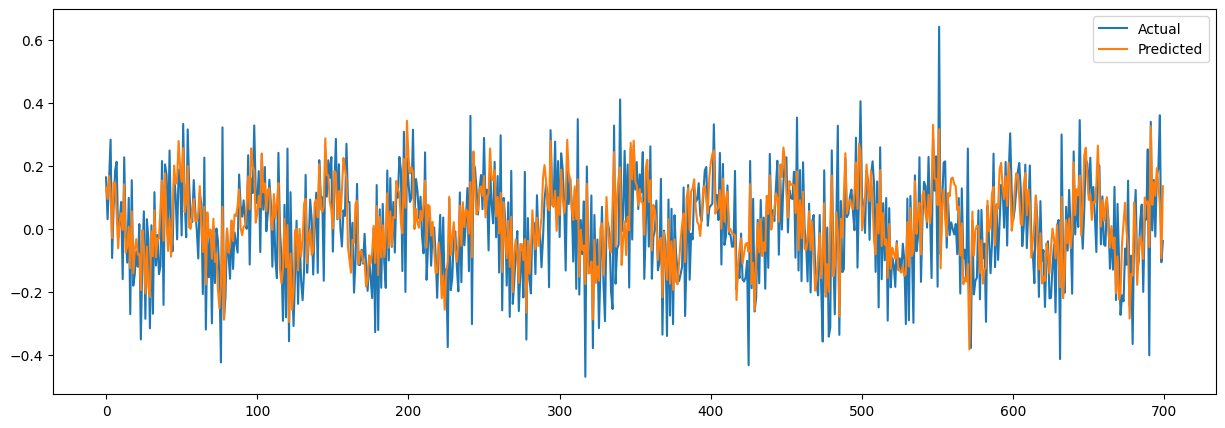

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(actuals_inv, label='Actual')
plt.plot(predictions_inv, label='Predicted')
plt.legend()
plt.show()